In [1]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

# Exploratory Data Analysis

### Import Libraries & CSV File

In [1]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [2]:
df=pd.read_csv('02_mushroom_species_data.csv') #Read the Csv File

In [3]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Mushroom Dataset EDA Report")
profile.to_notebook_iframe()  # This will display the report in Jupyter Notebook

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Key points derived from the report
1. The veil type can be removed as there is only one value for all the types of mushrooms
2. The gill attachment is removed too as it is highly correlated to 2 other columns: stalk color above ring and below ring 
3. There is one column: ring-number that is ordinal that has to be encoded correctly
4. Habitat column has missing values

In [4]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


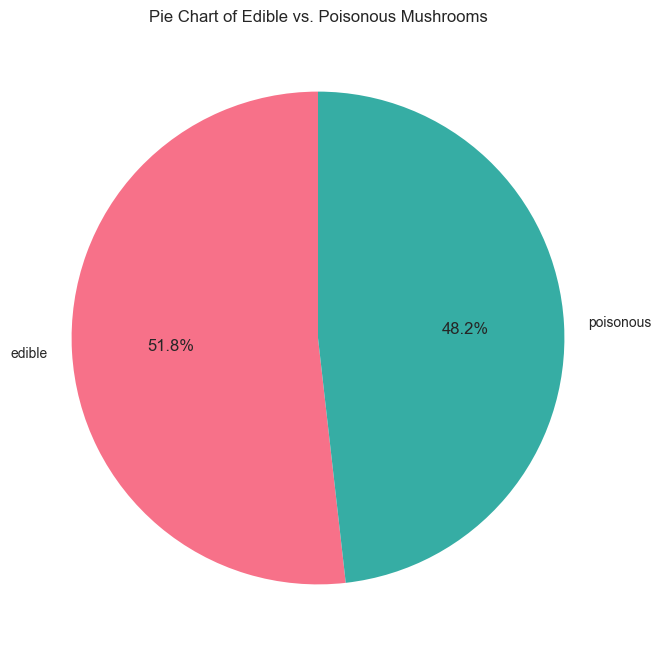

In [5]:
#piechart on the distribution of the target classes

# Plot a pie chart for the target variable 'class'
plt.figure(figsize=(8, 8))
df['class'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, colors=sns.color_palette('husl', 2)
)
plt.title('Pie Chart of Edible vs. Poisonous Mushrooms')
plt.ylabel('')  # Remove the y-label
plt.show()

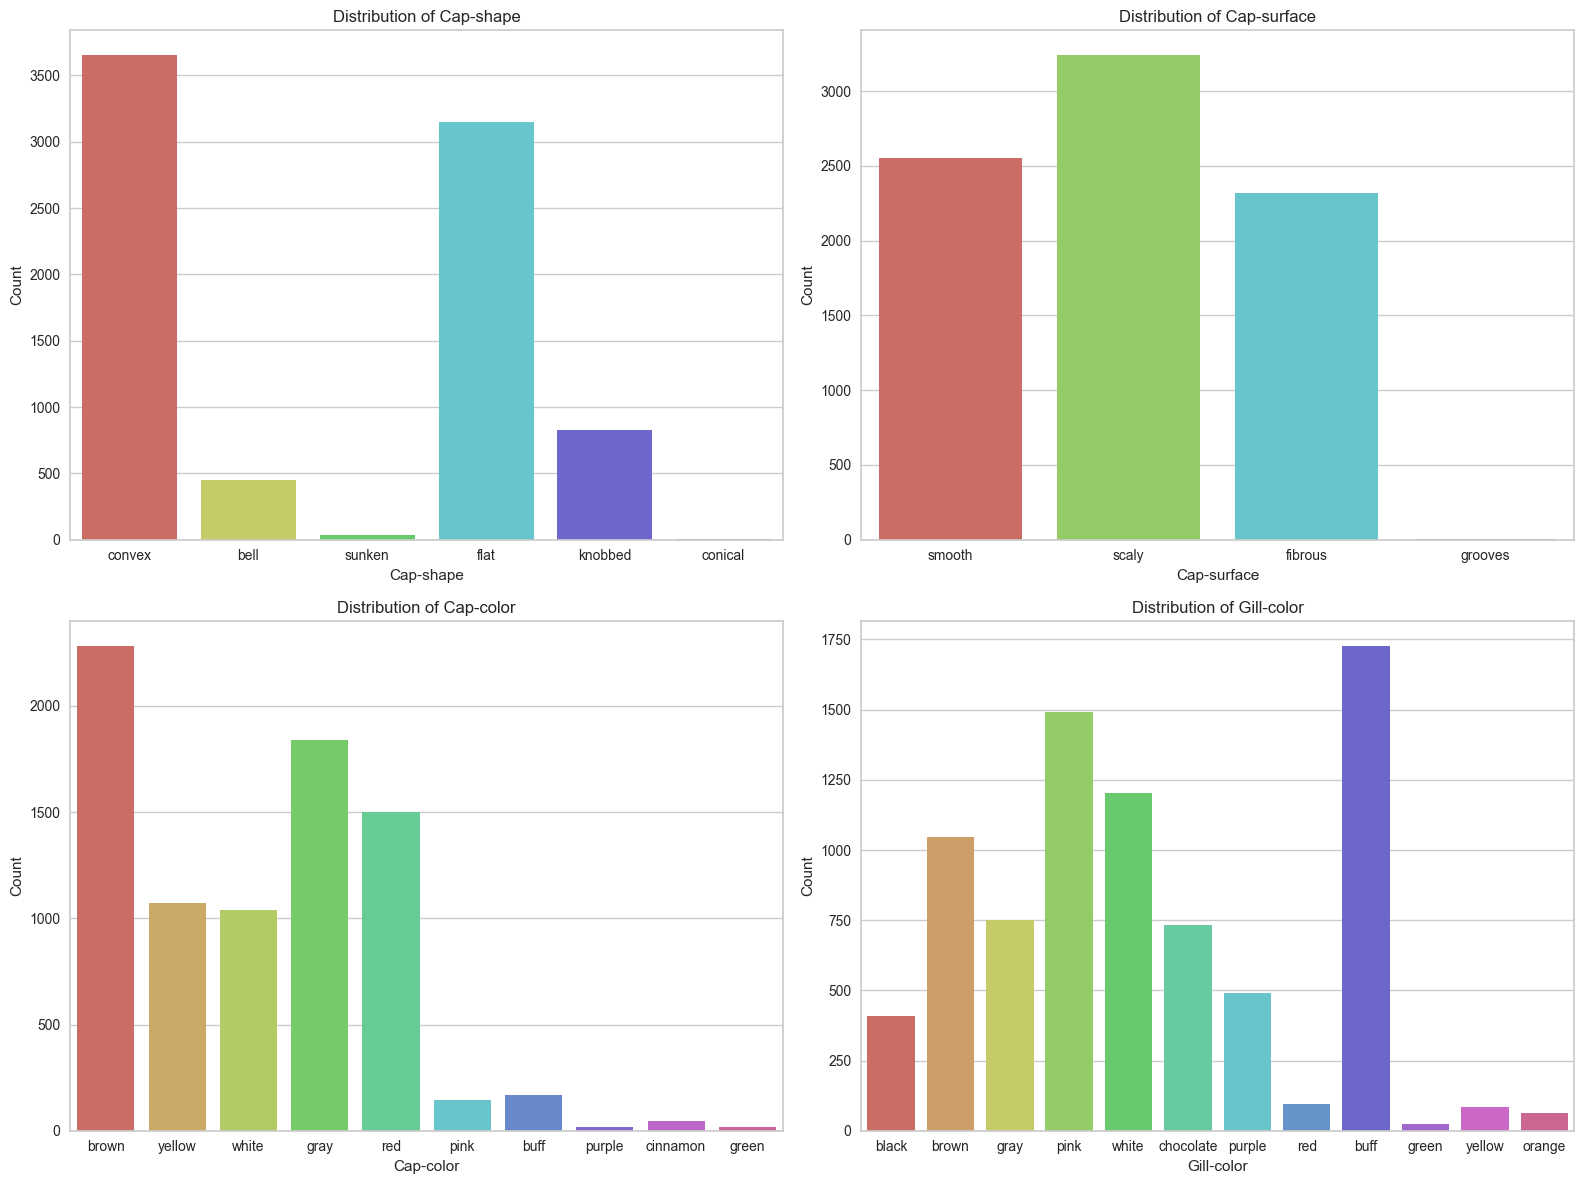

In [6]:
# Plotting histograms for selected categorical features
features = ['cap-shape', 'cap-surface', 'cap-color', 'gill-color']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, feature in enumerate(features):
    sns.countplot(data=df, x=feature, palette='hls', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {feature.capitalize()}')
    axes[i//2, i%2].set_xlabel(feature.capitalize())
    axes[i//2, i%2].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Key Points:
1. The most common cap shape is "convex," with a count exceeding 3500, followed by "flat," which has over 3000 occurrences. While "conical" is the least common.
2. The "scaly" surface is the most frequent,while "grooves" are rare
3. The "buff" gill color is most common, with about 1750 occurrences."Pink" and "gray" are also frequent, while "yellow," "orange," and "green" are among the least common.

### Setup

In [7]:
# import pycaret classification and init setup
s = setup(df, target = 'class', session_id = 123,ordinal_features={'ring-number': ['none', 'one', 'two']},ignore_features=['veil-type','gill-attachment'],log_experiment=True,experiment_name='mushroom-classification')

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(8124, 109)"
6,Transformed train set shape,"(5686, 109)"
7,Transformed test set shape,"(2438, 109)"
8,Ignore features,2
9,Ordinal features,1


2024/08/24 22:35:47 INFO mlflow.tracking.fluent: Experiment with name 'mushroom-classification' does not exist. Creating a new experiment.
2024/08/24 22:35:48 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
  

Session id (123): This is a random seed used to ensure reproducibility. By setting the session_id, you ensure that your results can be replicated in future runs.

Target (class): This indicates that the target variable (the variable you're trying to predict) is class, which likely represents whether a mushroom is poisonous or edible.

Target type (Binary): This confirms that the problem is a binary classification problem, with two possible outcomes (poisonous or edible).

Target mapping: This maps the target classes to numerical values: edible is mapped to 0 and poisonous to 1.

Original data shape (8124, 23): This shows the shape of the dataset before any transformations, with 8124 rows and 23 columns.

Transformed data shape (8124, 109): This is the shape of the dataset after transformations. The increase in the number of columns is likely due to one-hot encoding of categorical features.

Transformed train set shape (5686, 109): The shape of the training set after splitting the data, with 5686 rows and 109 columns.

Transformed test set shape (2438, 109): The shape of the test set after splitting the data, with 2438 rows and 109 columns.

Ignore features (2): This indicates that 2 features were ignored during model training. According to the setup, these are veil-type and gill-attachment.

Ordinal features (1): This indicates that one feature (ring-number) is treated as ordinal, meaning it has a meaningful order.

# Preprocessing

In [8]:
s.get_config('dataset_transformed')

,cap-shape_flat,cap-shape_convex,cap-shape_knobbed,cap-shape_bell,cap-shape_sunken,cap-shape_conical,cap-surface_smooth,cap-surface_scaly,cap-surface_fibrous,cap-surface_grooves,...,population_numerous,population_clustered,population_abundant,habitat_grasses,habitat_woods,habitat_path,habitat_meadows,habitat_leaves,habitat_urban,class
1287,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
6411,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4564,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3565,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3892,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


# Modelling

In [9]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.8970
svm,SVM - Linear Kernel,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1990
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2950
qda,Quadratic Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2080
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2840
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0310
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1770
dt,Decision Tree Classifier,0.9998,0.9998,0.9998,0.9998,0.9998,0.9996,0.9996,0.1800
ada,Ada Boost Classifier,0.9998,1.0000,0.9998,0.9998,0.9998,0.9996,0.9996,0.3100
ridge,Ridge Classifier,0.9996,1.0000,0.9996,0.9996,0.9996,0.9993,0.9993,0.1780


In [14]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [16]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


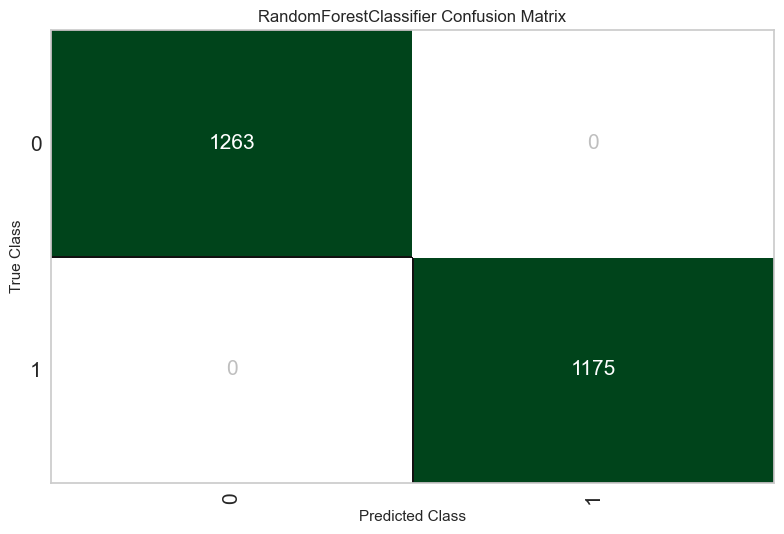

In [18]:
plot_model(rf, plot = 'confusion_matrix')

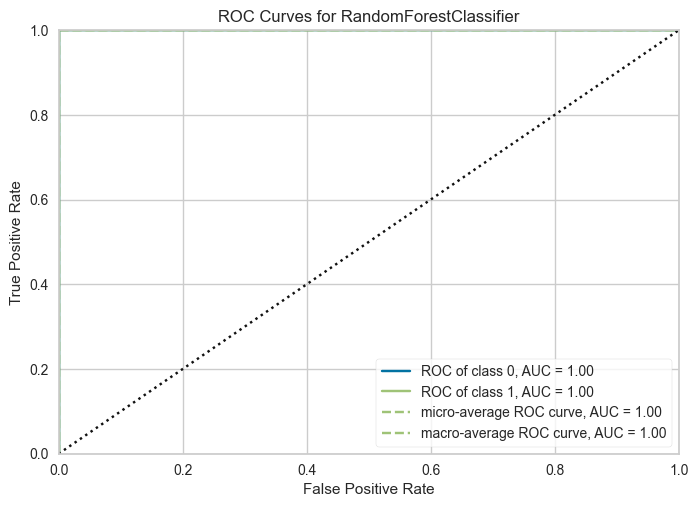

In [19]:
plot_model(rf, plot = 'auc')

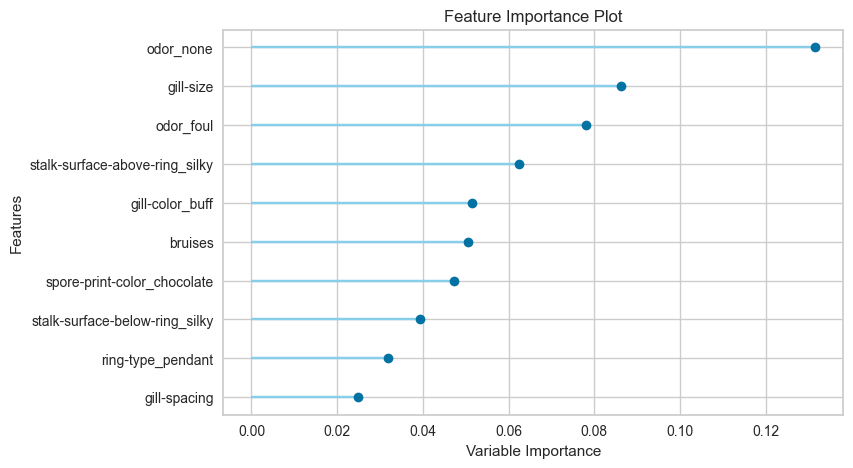

In [20]:
plot_model(rf, plot = 'feature')

no odor, gill size and foul odor is the  top 3 most important features

In [22]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
# predict on test set
holdout_pred = predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Chose RF as my best model to predict on my test set as its metrics was 1.0 while SVM and qda had less than 1.0 in testing

In [23]:
holdout_pred.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,...,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class,prediction_label,prediction_score
3370,flat,scaly,brown,bruises,none,close,broad,white,tapering,bulbous,...,gray,white,one,pendant,black,several,woods,edible,edible,1.0
4466,flat,fibrous,gray,no,foul,close,broad,chocolate,enlarging,bulbous,...,pink,white,one,large,chocolate,solitary,grasses,poisonous,poisonous,1.0
4232,flat,smooth,white,bruises,foul,close,broad,pink,tapering,bulbous,...,white,white,one,pendant,chocolate,scattered,urban,poisonous,poisonous,1.0
5058,convex,smooth,buff,bruises,foul,close,broad,white,tapering,bulbous,...,white,white,one,pendant,chocolate,scattered,urban,poisonous,poisonous,1.0
6305,convex,smooth,red,no,foul,close,narrow,buff,tapering,bulbous,...,pink,white,one,evanescent,white,several,path,poisonous,poisonous,1.0


In [24]:
new_data = df.copy()
new_data.drop('class', axis=1, inplace=True)
new_data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [25]:
predictions = predict_model(rf, data = new_data)
predictions.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,prediction_label,prediction_score
0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,...,white,partial,white,one,pendant,black,scattered,urban,poisonous,1.0
1,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,...,white,partial,white,one,pendant,brown,numerous,grasses,edible,1.0
2,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,...,white,partial,white,one,pendant,brown,numerous,meadows,edible,1.0
3,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,...,white,partial,white,one,pendant,black,scattered,urban,poisonous,1.0
4,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,...,white,partial,white,one,evanescent,brown,abundant,grasses,edible,1.0


In [26]:
# save pipeline
save_model(rf, 'mushroom')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
 

In [27]:
# load pipeline
mushroom_pipeline = load_model('mushroom')
mushroom_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\smile\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        monotonic_cst=None, n_estimators=100,
                                        n_jobs=-1, oob_score=False,
                                        random_state=123, verbose=0,
                                        warm_start=False))],
         verbose=False)